In [1]:
import matplotlib.pyplot as plt
from util import *
from partition import *
from group_testing import *
from origami_assays import *
from epidemics import *
from networkx.generators.community import gaussian_random_partition_graph

In [2]:
#TODO: Set these paths
data_folder = ""
figures_folder = ""

In [3]:
gamma = 1.5   #Recovery rate
tau = 40.   #Transmission rate
num_init = 1
trials = 10000
n_samples = 1000
repeat = 10
missing_edges = np.array([.05, .10, .20, .40, .80]) 
sizes = np.arange(2,7)
max_group_size = 64
group_approaches = ['Rand', 'Orig', 'Top-KL', 'Samp-KL']

origami_assays = [L3, L4, M2, XL3, XL4, XL6]

#High school
G = read_contact_net(data_folder+"High-School_data_2013.csv", 20)

print("#nodes = ", G.number_of_nodes())
print("#edges = ", G.number_of_edges())

#nodes =  327
#edges =  2141


In [6]:
avg_missing_edges_primary = np.zeros((len(group_approaches), missing_edges.shape[0]))
std_missing_edges_primary = np.zeros((len(group_approaches), missing_edges.shape[0]))

infec_matrix = sample_epidemics(G, tau, gamma, trials, 0.04, num_init, weight='weight')

for n in range(missing_edges.shape[0]):
    miss_edges = int(missing_edges[n] * G.number_of_edges())
    
    print("missing ", missing_edges[n])
    
    i = 0
    #Random
    if 'Rand' in group_approaches:
        all_res = np.zeros((repeat, trials))
        
        for r in range(repeat):
            G_miss = remove_edges(G, miss_edges)
            best_mean = 100 * G.number_of_nodes()
            for s in range(sizes.shape[0]):
                size = sizes[s]
                rand_groups = random_groups(G_miss, size)
                res = evaluate_two_level_group_testing(infec_matrix, rand_groups)

                if np.mean(res) < best_mean:
                    best_mean = np.mean(res)
                    all_res[r] = res
                 
        avg_missing_edges_primary[i][n] = np.mean(all_res)
        std_missing_edges_primary[i][n] = np.std(all_res)
        i = i + 1
                    
    #Origami
    if 'Orig' in group_approaches:
        all_res = np.zeros((repeat, trials))
        for r in range(repeat):
            best_mean = 100 * G.number_of_nodes()

            for s in range(len(origami_assays)):
                res = evaluate_origami_assay(np.mean(infec_matrix), origami_assays[s], trials)

                if np.mean(res) < best_mean:
                    best_mean = np.mean(res)
                    all_res[r] = res

        avg_missing_edges_primary[i][n] = np.mean(all_res)
        std_missing_edges_primary[i][n] = np.std(all_res)
        i = i + 1    
        
    #Kernighan-Lin topology
    if 'Top-KL' in group_approaches:
        all_res = np.zeros((repeat, trials))
        for r in range(repeat):
            G_miss = remove_edges(G, miss_edges)
            best_mean = 100 * G.number_of_nodes()

            for s in range(sizes.shape[0]):
                size = sizes[s]
                #print("size = ", size)
                top_kl =  topol_kernighan_lin(G_miss, size, weight='weight', n_iter=2)
                res = evaluate_two_level_group_testing(infec_matrix, top_kl)

                if np.mean(res) < best_mean:
                    best_mean = np.mean(res)
                    all_res[r] = res
            
        avg_missing_edges_primary[i][n] = np.mean(all_res)
        std_missing_edges_primary[i][n] = np.mean(all_res)
        i = i + 1
   
    #Kernighan-Lin sampling
    if 'Samp-KL' in group_approaches and missing_edges[n] < 0.8:
        all_res = np.zeros((repeat, trials))
        for r in range(repeat):
            samp_infec_matrix = sample_epidemics(G_miss, tau, gamma, n_samples, 0.04, num_init, weight='weight')

            G_miss = remove_edges(G, miss_edges)
            samp_kl = samp_kernighan_lin(G_miss, max_group_size, samp_infec_matrix)
            res = evaluate_two_level_group_testing(infec_matrix, samp_kl)
            all_res[r] = res
            
        avg_missing_edges_primary[i][n] = np.mean(all_res)
        std_missing_edges_primary[i][n] = np.std(all_res)
        
        i = i + 1

missing  0.05
missing  0.1
missing  0.2
missing  0.4
missing  0.8


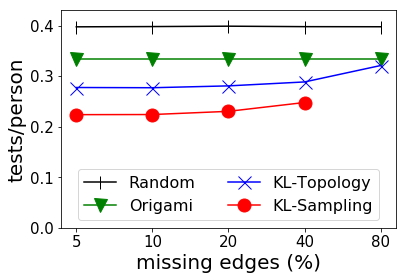

In [7]:
plt.figure()

plt.plot(np.arange(0,5), avg_missing_edges_primary[0], color='black', label='Random', marker='|', markersize=13)
plt.plot(np.arange(0,5), np.ones(missing_edges.shape[0])*avg_missing_edges_primary[1][-1], color='green', label='Origami', marker='v', markersize=13)
plt.plot(np.arange(0,5), avg_missing_edges_primary[2], color='blue', label='KL-Topology', marker='x', markersize=13)
plt.plot(np.arange(0,4), avg_missing_edges_primary[3][0:4], color='red', label='KL-Sampling', marker='o', markersize=13)

plt.xticks(np.arange(0,5), np.array(100*missing_edges,dtype=int))

plt.ylabel("tests/person", fontsize=20)
plt.xlabel("missing edges (%)", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(.1*np.arange(0,5), fontsize=15)
plt.legend(loc='lower center', fontsize=16, ncol=2)
plt.ylim(0,.43)

plt.savefig(figures_folder+"n_infected_tests_missing_high_school.pdf", bbox_inches='tight')